# State Recovery Analysis: Hidden Markov Model-Based Regime Detection and Parameter Estimation

## Overview

This notebook implements a regime-aware factor model using Hidden Markov Models (HMMs) to recover state-dependent factor loadings in equity returns. The analysis proceeds in three main stages:

1. **Real Data Analysis**: Estimate an HMM on observed Fama-French factors and compute regime-weighted factor loadings for sampled stocks
2. **Synthetic Data Generation**: Generate synthetic stock returns using parameters calibrated to empirical data
3. **Parameter Recovery**: Estimate factor loadings from simulated data and evaluate recovery accuracy

## Framework

We employ a multi-state factor model where stock returns are driven by regime-dependent exposures to systematic factors:

$$r_{i,t} = \alpha_i(s_t) + \sum_{j} \beta_{i,j}(s_t) f_{j,t} + \epsilon_{i,t}(s_t)$$

where $s_t$ denotes the latent market regime at time $t$. The regime evolution follows a Markov process, and factor loadings $\beta_{i,j}(s_t)$ vary with regimes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
from datetime import datetime
from statsmodels.stats.weightstats import DescrStatsW
import seaborn as sns
from regimeaware.constants import DataConstants, HMMParameters
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def match_columns(G, G_hat):
    """
    Reorders the columns of G_hat to match the order of columns in G
    by minimizing the total Euclidean distance between matched columns.
    """
    cost_matrix = cdist(G.T, G_hat.T, metric='euclidean')
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    G_hat_sorted = G_hat[:, col_ind]

    return G_hat_sorted, col_ind

NUM_STOCKS = 1000
SIM_PERIODS = 600
MIN_OBS = 300
FCTRS = ["mktrf", "smb", "hml", "rmw", "cma", "umd"]
AS_OF_DT = datetime(2024, 12, 31)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

dpi = 300
width = 7.5
height = 4.5

## Stage 1: Real Data and HMM Estimation

### 1.1 Data Loading and Sample Selection

We use Fama-French factors and CRSP stock return data, filtering for stocks with at least 300 observations of complete return history.

In [2]:
fctr_rt = pd.read_pickle(f"{DataConstants.WDIR.value}/data/ff.pkl").loc[:AS_OF_DT, FCTRS]
crsp = pd.read_pickle(f"{DataConstants.WDIR.value}/data/crsp.pkl")
sec_rt = crsp["excess_ret"]
mcap = crsp["mktcap"].xs(AS_OF_DT)

# Sample selection
obs_count = sec_rt.loc[:, pd.IndexSlice[mcap.index]].groupby("permno").count()
sample_ids = obs_count[obs_count >= MIN_OBS].index

### 1.2 Hidden Markov Model Estimation

We fit a Gaussian HMM on factor returns to extract the latent regime dynamics. The HMM learns the state transition matrix, regime probabilities, and factor means and covariances for each state.

In [3]:
# Train HMM based on real data
mdl_hmm = GaussianHMM(
    n_components=HMMParameters.STATES.value,
    covariance_type=HMMParameters.COV.value,
    random_state=HMMParameters.RS.value,
    min_covar=HMMParameters.MINCOV.value,
    tol=HMMParameters.TOL.value,
    implementation=HMMParameters.IMPLEMENTATION.value
)

mdl_hmm.fit(fctr_rt)
smoothed_prob = pd.DataFrame(mdl_hmm.predict_proba(fctr_rt), index=fctr_rt.index, columns=range(HMMParameters.STATES.value))
hmm_startprob = mdl_hmm.startprob_
hmm_transmat = mdl_hmm.transmat_
hmm_means = mdl_hmm.means_
hmm_covars = mdl_hmm.covars_

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


### 1.3 Regime-Weighted Factor Loading Estimation

For each stock in our sample, we estimate state-dependent factor loadings using weighted least squares (WLS), where weights are the smoothed regime probabilities from the fitted HMM:

$$\hat{\beta}_{i,j}(s) = \text{argmin}_{\beta} \sum_{t} \gamma_{t,s}(r_{i,t} - f_t' \beta)^2$$

where $\gamma_{t,s}$ are smoothed regime probabilities. We also compute the market-cap weighted distribution of factor loadings across stocks.

In [4]:
# Collect regime-weighted parameters of our sample stocks
collect_params = {}
collect_scale = {}
for sec_id in sample_ids:
    y = sec_rt.xs(sec_id, level="permno").dropna()
    
    state_params = []
    for s in range(HMMParameters.STATES.value):
        w = smoothed_prob.loc[y.index, s]
        mdl = sm.WLS(y, sm.add_constant(fctr_rt.reindex(y.index)[FCTRS]).astype(float), weights=w.values).fit(disp=0)
        b = mdl.params.copy()
        b.index = pd.MultiIndex.from_product([b.index, [s]], names=["factor", "state"])
        state_params += [b]
        collect_scale[(sec_id, s)] = mdl.scale

    collect_params[sec_id] = pd.concat(state_params)

_midx = pd.MultiIndex.from_product([FCTRS, range(HMMParameters.STATES.value)], names=["state", "factor"])
sample_params = pd.DataFrame.from_dict(collect_params, orient="index").loc[sample_ids, _midx]
scale_by_regime = pd.Series(collect_scale).groupby(level=1).mean()


# Loadings join-distribution (market-cap weighted)
wstats = DescrStatsW(sample_params, weights=mcap.reindex(sample_ids))

loadings_means = pd.Series(wstats.mean, index=_midx)

_temp_cov = pd.DataFrame(wstats.cov, index=_midx, columns=_midx, dtype=float)
loadings_cov = pd.DataFrame(0, index=_midx, columns=_midx, dtype=float)
for f in FCTRS:
    loadings_cov.loc[f, f] = _temp_cov.loc[f, f].values

## Stage 2: Synthetic Data Generation

### 2.1 Regime and Factor Simulation

We generate synthetic factor sequences using the estimated HMM parameters, producing regime indicators and factor realizations that preserve empirical factor dynamics and regime persistence.

In [5]:
# Generate synthetic stock returns
gen_hmm = GaussianHMM(
    n_components=HMMParameters.STATES.value,
    covariance_type=HMMParameters.COV.value,
    min_covar=HMMParameters.MINCOV.value,
    tol=HMMParameters.TOL.value,
    implementation=HMMParameters.IMPLEMENTATION.value
)

# Seeds
gen_hmm.random_state = HMMParameters.RS.value
np.random.seed(HMMParameters.RS.value)

gen_hmm.startprob_ = hmm_startprob
gen_hmm.transmat_ = hmm_transmat
gen_hmm.means_ = hmm_means
gen_hmm.covars_ = np.array([np.diag(x) for x in hmm_covars])

X, Z = gen_hmm.sample(SIM_PERIODS)
G = gen_hmm.predict_proba(X)

# True factor loadings
_vals = np.random.multivariate_normal(mean=loadings_means, cov=loadings_cov, size=NUM_STOCKS)
B = pd.DataFrame(_vals, columns=loadings_means.index).T
B.columns.name = "stock"
B.index.names = ["factor", "state"]
B = B.stack()

# Stock returns
R = np.zeros((SIM_PERIODS, NUM_STOCKS))
for _t, s_t in enumerate(Z):
    x_t = pd.Series(X[_t], FCTRS)
    x_t.index.name = "factor"
    R[_t] += B.xs(s_t, level="state").mul(x_t).groupby("stock").sum()
    R[_t] += np.random.normal(loc=0, scale=scale_by_regime[s_t], size=NUM_STOCKS)  # Resids

### 2.2 Stock Return Simulation

Stock returns are generated using:
- True factor loadings sampled from the empirical distribution
- Regime-dependent factor realizations from the HMM
- Idiosyncratic noise with regime-varying volatility

This ensures our synthetic data exhibits realistic risk factor structures and regime-dependent behavior.

## Stage 3: Parameter Recovery Analysis

### 3.1 HMM Re-estimation and Regime Matching

We fit a new HMM to the simulated factor data and match estimated regimes to true regimes using optimal assignment (Hungarian algorithm) to account for label-switching.

In [6]:
hat_hmm = GaussianHMM(
    n_components=HMMParameters.STATES.value,
    covariance_type=HMMParameters.COV.value,
    min_covar=HMMParameters.MINCOV.value,
    tol=HMMParameters.TOL.value,
    random_state=HMMParameters.RS.value,
    implementation=HMMParameters.IMPLEMENTATION.value
)
hat_hmm.fit(X)
G_hat = hat_hmm.predict_proba(X)

# Sort regime order for constitency
G_hat, _ = match_columns(G, G_hat)

# Estimated parameters
collect_params_hat = {}
for i in range(NUM_STOCKS):
    y = R[:, i]
    
    state_params = []
    for s in range(HMMParameters.STATES.value):
        w = G_hat[:, s]
        mdl = sm.WLS(y, X, weights=w).fit()
        _midx = pd.MultiIndex.from_product([FCTRS, [s]], names=["factor", "state"])
        b = pd.Series(mdl.params.copy(), index=_midx)
        state_params += [b]
        collect_scale[(i, s)] = mdl.scale

    collect_params_hat[i] = pd.concat(state_params)

B_hat = pd.DataFrame.from_dict(collect_params_hat).stack()
B_hat.index.names = ["factor", "state", "stock"]

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


### 3.2 State-Dependent Loading Recovery

Using the matched regimes, we estimate factor loadings for each simulated stock via weighted least squares with regime smoothing probabilities:

$$\hat{\beta}_{i,j}(s) = \text{argmin}_{\beta} \sum_{t} \hat{\gamma}_{t,s}(r_{i,t} - x_t' \beta)^2$$

This allows us to assess how well regime-weighted estimation recovers the true state-dependent loadings.

### 3.3 Loading Recovery Diagnostics

We generate joint scatter plots of true vs. estimated loadings by factor and regime. These visualizations reveal:
- Overall recovery accuracy (proximity to 45° line)
- Regime-specific estimation performance
- Potential systematic biases or estimation challenges

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


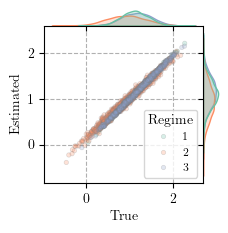

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


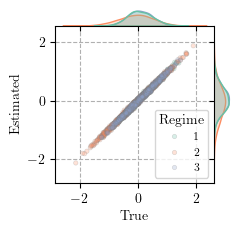

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


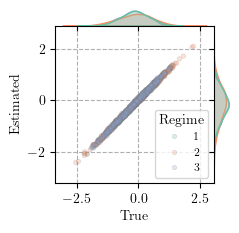

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


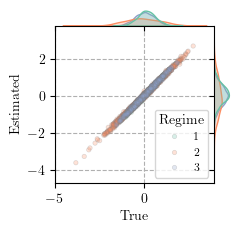

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


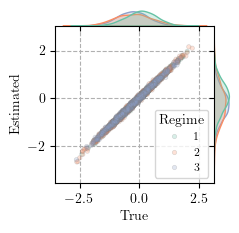

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


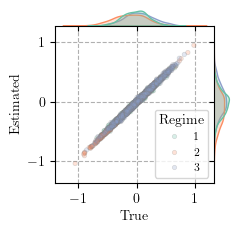

In [7]:
reco = pd.concat([B, B_hat], axis=1)
reco.columns = pd.Index(["True", "Estimated"], name="Loading")
reco.rename({0: 1, 1: 2, 2: 3}, level="state", inplace=True)

for f in FCTRS:
    data = reco.xs(f, level="factor")
    g = sns.jointplot(data, x="True", y="Estimated", hue="state", space=0, palette="Set2", zorder=25, marginal_kws=dict(bw_adjust=1), height=2.25, ratio=10, alpha=.25, joint_kws={'edgecolor': 'gray', 'linewidth': .5, 's': 10})
    g.ax_joint.grid(ls='--', zorder=-25)
    g.ax_joint.legend(loc="lower right", fontsize=8, markerscale=1, title="Regime")
    g.ax_joint.set_xlabel(f"True")
    g.ax_joint.set_ylabel(f"Estimated")
    plt.savefig(f"{DataConstants.WDIR.value}/img/recovery_{f}.pdf", dpi=50, transparent=False, bbox_inches='tight')
    plt.show()